# Use updated parameters and analysis to calculate the flux of a torsion

In [1]:
from __future__ import division, print_function

import datetime
import decimal
import glob
import inspect
import os as os
import sys

import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy as sc
from math import pi
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import genfromtxt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy import stats


%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
def update_label(old_label, exponent_text):
    if exponent_text == "":
        return old_label
    try:
        units = old_label[old_label.index("(") + 1:old_label.rindex(")")]
    except ValueError:
        units = ""
    label = old_label.replace("({})".format(units), "")
    
    exponent_text = exponent_text.replace("$\\times$", "")
    
    return "{} ({} {})".format(label, exponent_text, units)
    
def format_label_string_with_exponent(ax, axis='both'):  
    """ Format the label string with the exponent from the ScalarFormatter """
    ax.ticklabel_format(axis=axis, style='sci')

    axes_instances = []
    if axis in ['x', 'both']:
        axes_instances.append(ax.xaxis)
    if axis in ['y', 'both']:
        axes_instances.append(ax.yaxis)
    
    for ax in axes_instances:
        ax.major.formatter._useMathText = True
        plt.draw() # Update the text
        exponent_text = ax.get_offset_text().get_text()
        label = ax.get_label().get_text()
        ax.offsetText.set_visible(False)
        ax.set_label_text(update_label(label, exponent_text))


In [3]:
class simulation(object):
    def plot_energy(self):
        """
        This function plots the unbound and bound energies associated with a simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
        ax2.plot(range(self.bins), self.bound, c='b')
        ax2.set_title('Bound chemical-potential-like energies', y=1.05)
        plt.show()

    def plot_ss(self):
        """
        This function plots the steady-state distribution and Boltzmann PDF associated with a simulation object. 
        By default, this will plot the eigenvector-derived steady-state distribution.
        """
        boltzmann_unbound = np.exp(-self.unbound / self.kT)
        boltzmann_bound = np.exp(-self.bound / self.kT)
        self.PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound))
        self.PDF_bound = boltzmann_bound / np.sum((boltzmann_bound))

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.4, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.ss[0:self.bins], c='r', label='SS')
        ax1.plot(range(self.bins), self.PDF_unbound, c='k', label='PDF')
        ax1.legend()
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.set_title('Unbound steady-state', y=1.05)

        ax2.plot(range(self.bins), self.ss[self.bins:2 * self.bins], c='b', label='SS')
        ax2.plot(range(self.bins), self.PDF_bound, c='k', label='PDF')
        ax2.set_title('Bound steady-state', y=1.05)
        ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax2.legend()
       
        plt.show()

    def plot_flux(self, label=None):
        """
        This function plots the intrasurface flux sum and labels the graph with the attributions of the 
        simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 1, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(range(self.bins), self.flux_u, c='r', label='U')
        ax1.plot(range(self.bins), self.flux_b, c='b', label='B')
        ax1.plot(range(self.bins), self.flux_b + self.flux_u, c='k', label='U+B')
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.legend()
        if label is not None:
            ax1.set_title('{}: C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}, dt = {}'.format(label, self.C_intrasurface,
                                                                                           self.C_intersurface,
                                                                                           self.catalytic_rate,
                                                                                           self.cATP, self.dt), y=1.05)
        else:
            ax1.set_title(
                'Intra = {:6.2e}, Inter = {}, catalytic rate = {}, cATP = {}'.format(self.C_intrasurface, self.C_intersurface,
                                                                             self.catalytic_rate, self.cATP), y=1.05)
        plt.show()
        
        
    def data_to_energy(self, histogram):
        """    
        This function takes in population histograms from Chris' PKA data and
        (a) smoothes them with a Gaussian kernel with width 1;
        (b) eliminates zeros by setting any zero value to the minimum of the data;
        (c) turns the pouplation histograms to energy surfaces.
        """

        histogram_smooth = gaussian_filter(histogram, 1)
        histogram_copy = np.copy(histogram_smooth)
        for i in range(self.bins):
            if histogram_smooth[i] != 0:
                histogram_copy[i] = histogram_smooth[i]
            else:
                histogram_copy[i] = min(histogram_smooth[np.nonzero(histogram_smooth)])
        histogram_smooth = histogram_copy
        assert(not np.any(histogram_smooth == 0))
        energy = -self.kT * np.log(histogram_smooth)
        return energy


    def calculate_intrasurface_rates(self, energy_surface):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """
        forward_rates = self.C_intrasurface * np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        return rate_matrix
    
    
    def calculate_intrasurface_rates_with_load(self, energy_surface, load):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """
        # `load` should be np.array() with len(energy_surface)
        surface_with_load = energy_surface + load
        # This should handle the interior elements just fine.
        forward_rates = self.C_intrasurface * \
            np.exp(-1 * np.diff(suface_with_load) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * \
            np.exp(+1 * np.diff(surface_with_load) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]

        # But now the PBCs are a little tricky...
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] - (slope_of_load/1.0)
              - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] -
             energy_surface[0] + (slope_of_load/1.0)) / float(2 * self.kT))
        return rate_matrix    

    def calculate_intersurface_rates(self, unbound_surface, bound_surface):
        """
        This function calculates the intersurface rates in two ways.
        For bound to unbound, the rates are calculated according to the energy difference and the catalytic rate.
        For unbound to bound, the rates depend on the prefactor and the concentration of ATP.
        """
        bu_rm = np.empty((self.bins))
        ub_rm = np.empty((self.bins))
        for i in range(self.bins):
            bu_rm[i] = (self.C_intersurface *
                        np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
                        self.catalytic_rate)
            ub_rm[i] = self.C_intersurface * self.cATP
        return ub_rm, bu_rm

    def compose_tm(self, u_rm, b_rm, ub_rm, bu_rm):
        """
        We take the four rate matrices (two single surface and two intersurface) and inject them into the transition matrix.
        """
        tm = np.zeros((2 * self.bins, 2 * self.bins))
        tm[0:self.bins, 0:self.bins] = u_rm
        tm[self.bins:2 * self.bins, self.bins:2 * self.bins] = b_rm
        for i in range(self.bins):
            tm[i, i + self.bins] = ub_rm[i]
            tm[i + self.bins, i] = bu_rm[i]
        self.tm = self.scale_tm(tm)
        return

    def scale_tm(self, tm):
        """
        The transition matrix is scaled by `dt` so all rows sum to 1 and all elements are less than 1.
        This should not use `self` subobjects, except for `dt` because we are mutating the variables.
        """
        row_sums = tm.sum(axis=1, keepdims=True)
        maximum_row_sum = int(math.log10(max(row_sums)))
        self.dt = 10 ** -(maximum_row_sum + 1)
        tm_scaled = self.dt * tm
        row_sums = tm_scaled.sum(axis=1, keepdims=True)
        if np.any(row_sums > 1):
            print('Row sums unexpectedly greater than 1.')
        for i in range(2 * self.bins):
            tm_scaled[i][i] = 1.0 - row_sums[i]
        return tm_scaled

    def calculate_eigenvector(self):
        """
        The eigenvectors and eigenvalues of the transition matrix are computed and the steady-state population is
        assigned to the eigenvector with an eigenvalue of 1.
        """
        eigenvalues, eigenvectors = np.linalg.eig(np.transpose(self.tm))
        ss = abs(eigenvectors[:, eigenvalues.argmax()].astype(float))
        # print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
        self.ss = ss / np.sum(ss)
        return

    def calculate_flux(self, ss, tm):
        """
        This function calculates the intrasurface flux using the steady-state distribution and the transition matrix.
        The steady-state distribution is a parameter so this function can be run with either the eigenvector-derived
        steady-state distribution or the interated steady-state distribution.
        """
        flux_u = np.empty((self.bins))
        flux_b = np.empty((self.bins))
        for i in range(self.bins):
            if i == 0:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == self.bins - 1:
                flux_u[i] = - ss[i] * tm[i][0] / self.dt + ss[0] * tm[0][i] / self.dt
            else:
                flux_u[i] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        for i in range(self.bins, 2 * self.bins):
            if i == self.bins:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
            if i == 2 * self.bins - 1:
                flux_b[i - self.bins] = - ss[i] * tm[i][self.bins] / self.dt + ss[self.bins] * tm[self.bins][i] / self.dt
            else:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt
        self.flux_u = flux_u
        self.flux_b = flux_b
        return

    def iterate(self, iterations=None):
        """
        A template population distribution is multiplied by the transition matrix. 
        By default, iterations are 0. The output of this command is set to
        `self.iterative_ss` which can be passed to `calculate_flux`. 
        The new population can be set to a normalized random distribution or the eigenvector-derived 
        steady-state distribution.
        """
        print('Running iterative method with {} iterations'.format(self.iterations))
        population = np.random.rand(2 * self.bins)
        row_sums = population.sum(axis=0, keepdims=True)
        population = population / row_sums
        iterations = 0
        if self.ss is not None:
            new_population = self.ss
        for i in range(self.iterations):
            new_population = np.dot(new_population, self.tm)
        self.iterative_ss = new_population
        return
    
    def JSD(self):
        """
        Calculate the Jensen-Shannon divergence between the two surfaces.
        Using energy instead of probability right now.
        """
        from scipy.stats import entropy
        from numpy.linalg import norm
        _P = self.unbound / norm(self.unbound, ord=1)
        _Q = self.bound / norm(self.bound, ord=1)
        _M = 0.5 * (_P + _Q)
        return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))
    
    def JSD_2(self): #Jensen-shannon divergence
        x = np.array(self.unbound)
        y = np.array(self.bound)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d
    
    def JSD_3(self, x, y): #Jensen-shannon divergence
        x = np.array(x)
        y = np.array(y)
        d1 = x*np.log2(2*x/(x+y))
        d2 = y*np.log2(2*y/(x+y))
        d1[np.isnan(d1)] = 0
        d2[np.isnan(d2)] = 0
        d = 0.5*np.sum(d1+d2)    
        return d

    def simulate(self, plot=False):
        """
        This function runs the `simulation` which involves:
        (a) setting the unbound intrasurface rates,
        (b) setting the bound intrasurface rates,
        (c) setting the intersurface rates,
        (d) composing the transition matrix,
        (e) calculating the eigenvectors of the transition matrix,
        (f) calculating the intrasurface flux,
        and optionally (g) running an interative method to determine the steady-state distribution.
        """
        
        if not self.load:
            u_rm = self.calculate_intrasurface_rates(self.unbound)
            b_rm = self.calculate_intrasurface_rates(self.bound)
        if self.load:
            u_rm = self.calculate_intrasurface_rates_with_load(self.unbound, load)
            b_rm = self.calculate_intrasurface_rates_with_load(self.bound, load)
        ub_rm, bu_rm = self.calculate_intersurface_rates(self.unbound, self.bound)
        self.compose_tm(u_rm, b_rm, ub_rm, bu_rm)
        self.calculate_eigenvector()
        self.calculate_flux(self.ss, self.tm)
        if plot:
            self.plot_energy()
            self.plot_ss()
            self.plot_flux(label='Eigenvector method')
        if self.iterations != 0:
            self.iterate(self.iterations)
            self.calculate_flux(self.iterative_ss, self.tm)
            if plot:
                self.plot_flux(label='Iterative method')
        return


    def __init__(self):
        """
        These values are assigned to a new object, unless overridden later.
        """
        self.kT = 0.6
        # C_intrasurface depends on the number of bins, too. See the updated value down below.
        self.C_intrasurface_0 = 1.37 * 10 ** 14 # degrees/second
        self.cATP = 30
        self.offset_factor = 6.25
        self.catalytic_rate = 140
        self.unbound = np.array([saw(i, 20) for i in range(20)])
        self.bound = np.array([saw(i + 10, 20) for i in range(20)])
        self.bins = len(self.unbound)
        self.tm = np.zeros((self.bins, self.bins))
        self.iterations=0
        self.C_intrasurface = self.C_intrasurface_0 / (360. / self.bins)
        # Don't do the torque calculation...
        self.load = False



In [4]:
def saw(x, a):
    return 2 * (x / a - np.floor(1 / 2 + x / a))


def variable_saw(y, x, a):
    return y * (x / a - np.floor(1 / 2 + x / a))

In [5]:
def generate_candidates(low, high, bins):
    "Generate some candidate load functions within some parameter space."
    load = np.linspace(low, high, bins)
    return load

In [132]:
class torque(object):
    def plot_energy(self):
        """
        This function plots the unbound and bound energies associated with a simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
        ax2.plot(range(self.bins), self.bound, c='b')
        ax2.set_title('Bound chemical-potential-like energies', y=1.05)
        plt.show()

    def plot_ss(self):
        """
        This function plots the steady-state distribution and Boltzmann PDF associated with a simulation object. 
        By default, this will plot the eigenvector-derived steady-state distribution.
        """
        boltzmann_unbound = np.exp(-self.unbound / self.kT)
        boltzmann_bound = np.exp(-self.bound / self.kT)
        self.PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound))
        self.PDF_bound = boltzmann_bound / np.sum((boltzmann_bound))

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.4, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.ss[0:self.bins], c='r', label='SS')
#         ax1.plot(range(self.bins), self.PDF_unbound, c='k', label='PDF')
        ax1.legend()
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.set_title('Unbound steady-state', y=1.05)

        ax2.plot(range(self.bins), self.ss[self.bins:2 * self.bins], c='b', label='SS')
#         ax2.plot(range(self.bins), self.PDF_bound, c='k', label='PDF')
        ax2.set_title('Bound steady-state', y=1.05)
        ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax2.legend()
       
        plt.show()

    def plot_flux(self, label=None):
        """
        This function plots the intrasurface flux sum and labels the graph with the attributions of the 
        simulation object.
        """
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 1, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(range(self.bins), self.flux_u, c='r', label='U')
        ax1.plot(range(self.bins), self.flux_b, c='b', label='B')
        ax1.plot(range(self.bins), self.flux_b + self.flux_u, c='k', label='U+B')
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.legend()
        if label is not None:
            ax1.set_title('{}: C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}, dt = {}'.format(label, self.C_intrasurface,
                                                                                           self.C_intersurface,
                                                                                           self.catalytic_rate,
                                                                                           self.cATP, self.dt), y=1.05)
        else:
            ax1.set_title(
                'Intra = {:6.2e}, Inter = {}, catalytic rate = {}, cATP = {}'.format(self.C_intrasurface, self.C_intersurface,
                                                                             self.catalytic_rate, self.cATP), y=1.05)
        plt.show()
        
    def plot_load(self):
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.4, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.plot(range(self.bins), [self.unbound[i] + self.load_function(i) for i in range(self.bins)], c='k')
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.set_title('Unbound', y=1.05)

        ax2.plot(range(self.bins), self.bound, c='b', label='SS')
        ax2.plot(range(self.bins), [self.bound[i] + self.load_function(i) for i in range(self.bins)], c='k', label='PDF')
        ax2.set_title('Bound', y=1.05)
        ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))

        plt.show()  
        
    def plot_load_extrapolation(self):
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2, wspace=0.4, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        
        extended_u = np.tile(self.unbound, 4)
        extended_b = np.tile(self.bound, 4)
        
        ax1.plot(range(-2*self.bins, 2*self.bins), [extended_u[i] + self.load_function(i) for i in np.arange(-2*self.bins, 2*self.bins)], c='k')
        print([extended_u[i] + self.load_function(i) for i in np.arange(-2*self.bins, 2*self.bins)])
        ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        ax1.set_title('Unbound', y=1.05)

        ax2.plot(range(-2*self.bins, 2*self.bins), [extended_b[i] + self.load_function(i) for i in np.arange(-2*self.bins, 2*self.bins)], c='k')
        ax2.set_title('Bound', y=1.05)
        ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
        
#         import matplotlib.patches as patches
#         ax1.add_patch(
#             patches.Rectangle(
#             (-self.bins/2, min(self.bound[i]+self.load_function(i) for i in np.arange(self.bins))), # (x,y)
#             self.bins, # width
#             max(self.bound[i]+self.load_function(i) for i in np.arange(self.bins)) - 
#                 min(self.bound[i]+self.load_function(i) for i in np.arange(self.bins)), # height
#             fill=False,
#             edgecolor='b',
#             alpha = 1.0,
#             lw = 2
#             )
#         )

        plt.show()  
        
        
    def data_to_energy(self, histogram):
        """    
        This function takes in population histograms from Chris' PKA data and
        (a) smoothes them with a Gaussian kernel with width 1;
        (b) eliminates zeros by setting any zero value to the minimum of the data;
        (c) turns the pouplation histograms to energy surfaces.
        """

        histogram_smooth = gaussian_filter(histogram, 1)
        histogram_copy = np.copy(histogram_smooth)
        for i in range(self.bins):
            if histogram_smooth[i] != 0:
                histogram_copy[i] = histogram_smooth[i]
            else:
                histogram_copy[i] = min(histogram_smooth[np.nonzero(histogram_smooth)])
        histogram_smooth = histogram_copy
        assert(not np.any(histogram_smooth == 0))
        energy = -self.kT * np.log(histogram_smooth)
        return energy


    def calculate_intrasurface_rates(self, energy_surface):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """
        forward_rates = self.C_intrasurface * np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] - energy_surface[0]) / float(2 * self.kT))
        return rate_matrix
    
    
    def calculate_intrasurface_rates_with_load(self, energy_surface):
        """
        This function calculates intrasurface rates using the energy difference between adjacent bins.
        """

        surface_with_load = [energy_surface[i] + self.load_function(i) for i in range(self.bins)]
        # This should handle the interior elements just fine.
        self.forward_rates = self.C_intrasurface * \
            np.exp(-1 * np.diff(surface_with_load) / float(2 * self.kT))
        self.backward_rates = self.C_intrasurface * \
            np.exp(+1 * np.diff(surface_with_load) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = self.forward_rates[i]
            rate_matrix[i + 1][i] = self.backward_rates[i]

        # But now the PBCs are a little tricky...
        rate_matrix[0][self.bins - 1] = self.C_intrasurface * np.exp(
            -(energy_surface[self.bins - 1] + self.load_function(-1)
            -(energy_surface[0] + self.load_function(0))) / float(2 * self.kT))
  
        rate_matrix[self.bins - 1][0] = self.C_intrasurface * np.exp(
            +(energy_surface[self.bins - 1] + self.load_function(self.bins - 1)-
             (energy_surface[0] + self.load_function(self.bins))) / float(2 * self.kT))
    
#         print(np.diff(surface_with_load))
#         print(rate_matrix)
    
        return rate_matrix    

    def calculate_intersurface_rates(self, unbound_surface, bound_surface):
        """
        This function calculates the intersurface rates in two ways.
        For bound to unbound, the rates are calculated according to the energy difference and the catalytic rate.
        For unbound to bound, the rates depend on the prefactor and the concentration of ATP.
        """
        bu_rm = np.empty((self.bins))
        ub_rm = np.empty((self.bins))
        for i in range(self.bins):
            bu_rm[i] = (self.C_intersurface *
                        np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
                        self.catalytic_rate)
            ub_rm[i] = self.C_intersurface * self.cATP
        return ub_rm, bu_rm
    

    def compose_tm(self, u_rm, b_rm, ub_rm, bu_rm):
        """
        We take the four rate matrices (two single surface and two intersurface) and inject them into the transition matrix.
        """
        tm = np.zeros((2 * self.bins, 2 * self.bins))
        tm[0:self.bins, 0:self.bins] = u_rm
        tm[self.bins:2 * self.bins, self.bins:2 * self.bins] = b_rm
        for i in range(self.bins):
            tm[i, i + self.bins] = ub_rm[i]
            tm[i + self.bins, i] = bu_rm[i]
        self.tm = self.scale_tm(tm)
        return

    def scale_tm(self, tm):
        """
        The transition matrix is scaled by `dt` so all rows sum to 1 and all elements are less than 1.
        This should not use `self` subobjects, except for `dt` because we are mutating the variables.
        """
        row_sums = tm.sum(axis=1, keepdims=True)
        maximum_row_sum = int(math.log10(max(row_sums)))
        self.dt = 10 ** -(maximum_row_sum + 1)
        tm_scaled = self.dt * tm
        row_sums = tm_scaled.sum(axis=1, keepdims=True)
        if np.any(row_sums > 1):
            print('Row sums unexpectedly greater than 1.')
        for i in range(2 * self.bins):
            tm_scaled[i][i] = 1.0 - row_sums[i]
        return tm_scaled

    def calculate_eigenvector(self):
        """
        The eigenvectors and eigenvalues of the transition matrix are computed and the steady-state population is
        assigned to the eigenvector with an eigenvalue of 1.
        """
        eigenvalues, eigenvectors = np.linalg.eig(np.transpose(self.tm))
        ss = abs(eigenvectors[:, eigenvalues.argmax()].astype(float))
        print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
        self.ss = ss / np.sum(ss)
        return

    def calculate_flux(self, ss, tm):
        """
        This function calculates the intrasurface flux using the steady-state distribution and the transition matrix.
        The steady-state distribution is a parameter so this function can be run with either the eigenvector-derived
        steady-state distribution or the interated steady-state distribution.
        """
        flux_u = np.empty((self.bins))
        flux_b = np.empty((self.bins))
        for i in range(self.bins):
            if i == 0:
                flux_u[i] = -1*(- ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt)
            if i == self.bins - 1:
                flux_u[i] = -1*(- ss[i] * tm[i][0] / self.dt + ss[0] * tm[0][i] / self.dt)
            else:
                flux_u[i] = -1*(- ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt)
        for i in range(self.bins, 2 * self.bins):
            if i == self.bins:
                flux_b[i - self.bins] = -1*(- ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt)
            if i == 2 * self.bins - 1:
                flux_b[i - self.bins] = -1*(- ss[i] * tm[i][self.bins] / self.dt + ss[self.bins] * tm[self.bins][i] / self.dt)
            else:
                flux_b[i - self.bins] = -1*(- ss[i] * tm[i][i + 1] / self.dt + ss[i + 1] * tm[i + 1][i] / self.dt)
        self.flux_u = flux_u
        self.flux_b = flux_b
        return

    def iterate(self, iterations=None):
        """
        A template population distribution is multiplied by the transition matrix. 
        By default, iterations are 0. The output of this command is set to
        `self.iterative_ss` which can be passed to `calculate_flux`. 
        The new population can be set to a normalized random distribution or the eigenvector-derived 
        steady-state distribution.
        """
        print('Running iterative method with {} iterations'.format(self.iterations))
        population = np.random.rand(2 * self.bins)
        row_sums = population.sum(axis=0, keepdims=True)
        population = population / row_sums
        iterations = 0
        if self.ss is not None:
            new_population = self.ss
        for i in range(self.iterations):
            new_population = np.dot(new_population, self.tm)
        self.iterative_ss = new_population
        return
    

    def simulate(self, plot=False):
        """
        This function runs the `simulation` which involves:
        (a) setting the unbound intrasurface rates,
        (b) setting the bound intrasurface rates,
        (c) setting the intersurface rates,
        (d) composing the transition matrix,
        (e) calculating the eigenvectors of the transition matrix,
        (f) calculating the intrasurface flux,
        and optionally (g) running an interative method to determine the steady-state distribution.
        """
        
        if not self.load:
            u_rm = self.calculate_intrasurface_rates(self.unbound)
            b_rm = self.calculate_intrasurface_rates(self.bound)
        if self.load:
            u_rm = self.calculate_intrasurface_rates_with_load(self.unbound)
            b_rm = self.calculate_intrasurface_rates_with_load(self.bound)
    
        ub_rm, bu_rm = self.calculate_intersurface_rates(self.unbound, self.bound)
        self.compose_tm(u_rm, b_rm, ub_rm, bu_rm)
        self.calculate_eigenvector()
        self.calculate_flux(self.ss, self.tm)
        if plot:
            if not self.load: 
                self.plot_energy()
            else:
                self.plot_load()
            self.plot_ss()
            self.plot_flux(label='Eigenvector method')
        if self.iterations != 0:
            self.iterate(self.iterations)
            self.calculate_flux(self.iterative_ss, self.tm)
            if plot:
                self.plot_flux(label='Iterative method')
        return
    
    def load_function(self, x):
        return x * self.load_slope / self.bins

    def __init__(self):
        """
        These values are assigned to a new object, unless overridden later.
        """
        self.kT = 0.6
        self.C_intrasurface_0 = 1.37 * 10 ** 14 # degrees per second per bin
        self.cATP = 2 * 10**-6                  # moles
        self.offset_factor = 6.25               # kcal per mol
        self.catalytic_rate = 140               # per second
        self.unbound = [0]*60                   
        self.bound = [1]*60
        self.bins = len(self.unbound)
        self.tm = np.zeros((self.bins, self.bins))
        self.iterations = 0
        self.C_intrasurface = self.C_intrasurface_0 / (360. / self.bins) # degrees per second
        self.load = True
        if self.load:
            self.load_slope = self.bins          # kcal per mol per (2 * pi) radians
        else:
            # Untested
            self.load_slope = 0


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:237: ComplexWarning: Casting complex values to real discards the imaginary part


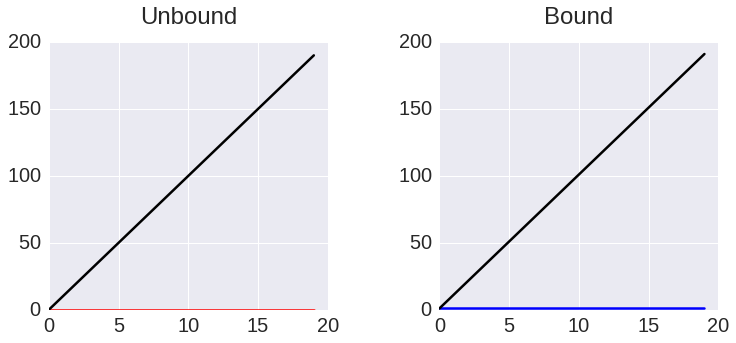

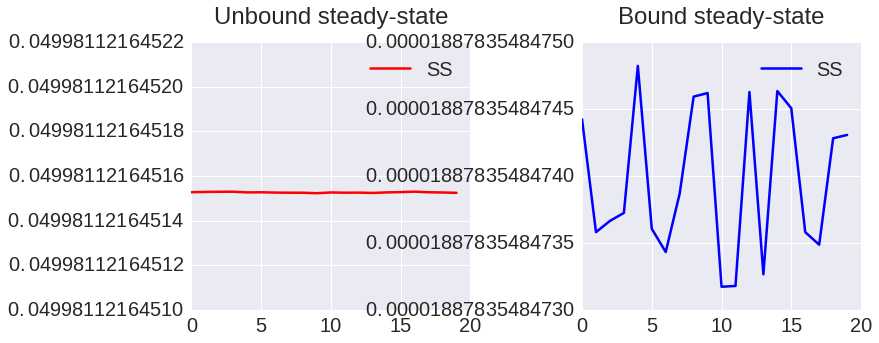

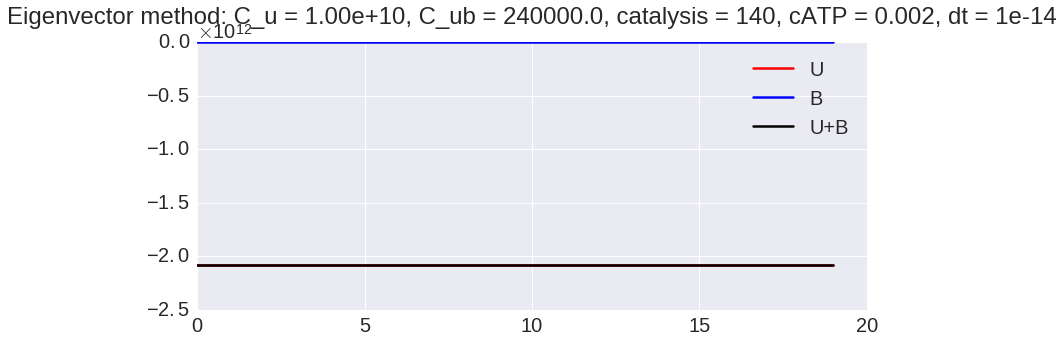

-2080130882502.7903 +/- 0.0017520833485485138


In [107]:
this = torque()
# this.unbound = np.array([0*np.cos(2*pi*i/30) for i in range(30)])
# this.bound = np.array([1*np.sin(2*pi*i/30) for i in range(30)])

# this.unbound = np.array([0]*20+[1]*10+[0]*20)
# this.bound = np.array([-5]*20+[-6]*10+[-5]*20)

this.unbound = np.array([0]*20)
this.bound = np.array([1]*20)

this.bins = len(this.unbound)

this.load = True
this.load_slope = 200

this.tm = np.zeros((this.bins, this.bins))
this.C_intrasurface = 10**10
this.catalytic_rate = 140

this.cATP = 2000 * 10**-6
this.C_intersurface = 0.24 * 10**6
this.iterations = 0
this.simulate(plot=True)

# this.plot_ss()
# this.plot_load_extrapolation()

print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))


In [100]:
print(this.tm)

[[ 0.79982636  0.09591895  0.         ...,  0.          0.          0.        ]
 [ 0.10425469  0.79982636  0.09591895 ...,  0.          0.          0.        ]
 [ 0.          0.10425469  0.79982636 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.79981366  0.09591895  0.        ]
 [ 0.          0.          0.         ...,  0.10425469  0.79981366
   0.09591895]
 [ 0.          0.          0.         ...,  0.          0.10425469
   0.79981366]]


10000000000.0
0.0 +/- 1.6977032497322654e-06
9917012926.39
-833342.9784285539 +/- 8.794600141396879e-07


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:237: ComplexWarning: Casting complex values to real discards the imaginary part


9834714538.22
-1666743.8282321747 +/- 2.4969385748113794e-06
9753099120.28
-2500260.4248048062 +/- 2.0459031170801703e-06
9672161004.82
-3333950.6515784026 +/- 6.778232752701437e-06
9591894571.09
-4167872.4040426617 +/- 3.222547240803236e-06
9512294245.01
-5002083.593765507 +/- 1.6826766545297753e-06
9433354498.73
-5836642.15241481 +/- 2.9545736152951547e-06
9355069850.32
-6671606.035781425 +/- 1.212608303529257e-06
9277434863.29
-7507033.227803941 +/- 2.089645060154193e-06
9200444146.29
-8342981.744595282 +/- 1.629748290660176e-06
9124092352.73
-9179509.638471756 +/- 2.4899218154689506e-06
9048374180.36
-10016675.001984403 +/- 2.6027359546243195e-06
8973284370.94
-10854535.971953224 +/- 1.1152643428458435e-06
8898817709.88
-11693150.733504528 +/- 6.2642212355369996e-06
8824969025.85
-12532577.524111547 +/- 2.3724320499253484e-06
8751733190.43
-13372874.637638755 +/- 2.1149377043071556e-06
8679105117.78
-14214100.428390076 +/- 1.305657677777632e-06
8607079764.25
-15056313.31516127 +/- 

/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


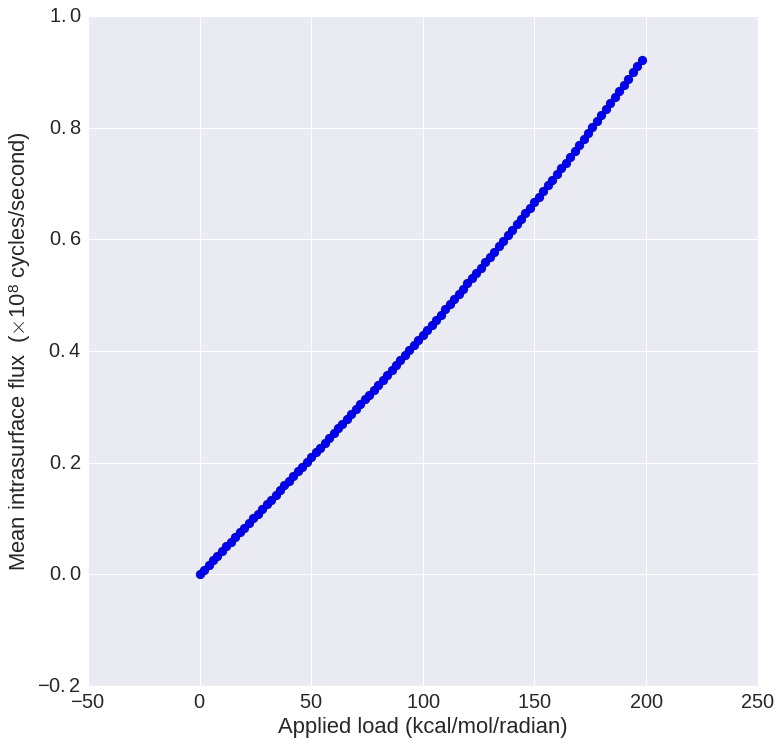

In [114]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])


for load in np.arange(0, 200, 2):

    this = torque()
    this.unbound = np.array([0*np.cos(2*pi*i/200) for i in range(200)])
#     this.unbound = np.array([0]*20+[100]*10+[0]*20)
    this.bound = np.array([0*np.sin(2*pi*i/200) for i in range(200)])
    this.bins = len(this.unbound)

    this.load = True
    this.load_slope = load

    this.tm = np.zeros((this.bins, this.bins))
    this.C_intrasurface = 10**10
    this.catalytic_rate = 140
    this.cATP = 2000 * 10**-6
    this.C_intersurface = 0.24 * 10**6
    ###########################################
    this.C_intersurface = 0
    ##########################################
    this.iterations = 0
    this.simulate(plot=False)
    #this.plot_load()
    #this.plot_flux()
    #this.plot_load_extrapolation()
#     print(this.forward_rates[0])
    print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))
    ax1.scatter(load, -1*np.mean(this.flux_u+this.flux_b), s=80)
ax1.legend()
ax1.set_ylabel('Mean intrasurface flux (cycles/second)')
ax1.set_xlabel('Applied load (kcal/mol/radian)')
# ax1.set_ylim([0, 0.0001])
# ax1.set_yscale('log')
# import matplotlib.ticker as ptick
# # ax1.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
# ax1.get_yaxis().get_offset_text().set_y(0)
format_label_string_with_exponent(ax1)


plt.show()

ValueError: x and y must be the same size

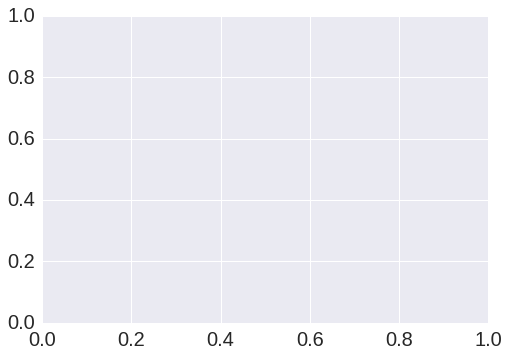

In [104]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter([x for x in np.arange(0, 50, 1)], [-1*(np.exp(-x/2) - np.exp(x/2)) for x in np.arange(0, 50, 0.1)])
ax.set_yscale('log')
ax.set_ylim([10**0, 10**11])
# format_label_string_with_exponent(ax)

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:237: ComplexWarning: Casting complex values to real discards the imaginary part


Maximum eigenvalue = (1.0000000000000007+0j)
-257213.55373953254 +/- 1.7060918458086449e-07
Maximum eigenvalue = (0.9999999999999984+0j)
-257204.6229717737 +/- 3.900332213601331e-07
Maximum eigenvalue = (0.999999999999997+0j)
-257202.9691463107 +/- 3.1417067488138554e-06
Maximum eigenvalue = (1.0000000000000016+0j)
-257202.39030890635 +/- 1.7958781139972332e-06
Maximum eigenvalue = (1.0000000000000013+0j)
-257202.12239014273 +/- 6.977690280531039e-07
Maximum eigenvalue = (0.999999999999998+0j)
-257201.97685410152 +/- 2.3252095932789014e-06
Maximum eigenvalue = (1.0000000000000007+0j)
-257201.8891004723 +/- 8.466396334767349e-07
Maximum eigenvalue = (1.0000000000000013+0j)
-257201.83214500677 +/- 1.9250893637566694e-06
Maximum eigenvalue = (0.999999999999999+0j)
-257201.7930965365 +/- 1.3266373713140467e-05


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


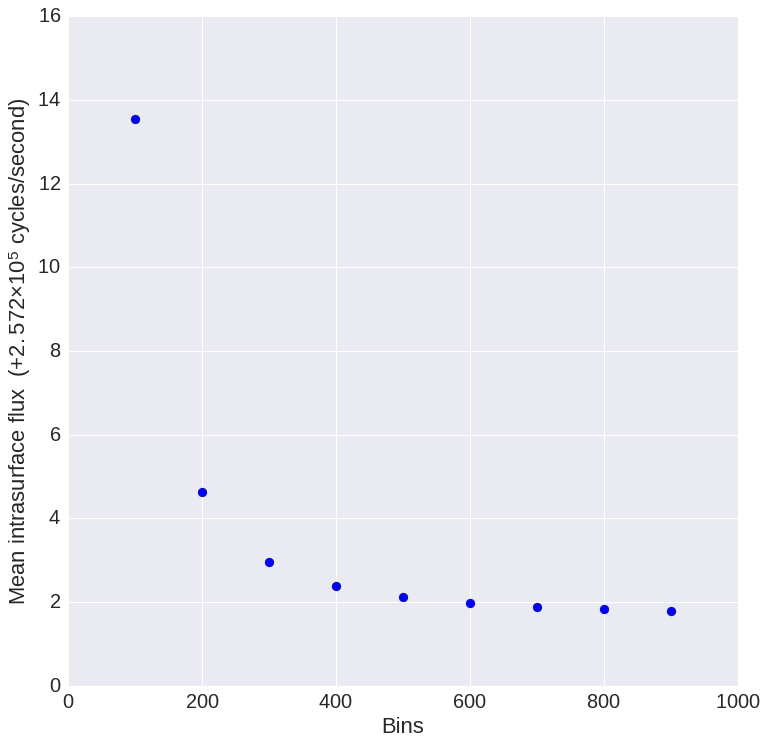

In [135]:
dir              = '/home/dslochower/Dropbox/Shared with Mike/ProteinKinaseATorsions/'
unbound_files    = sorted(glob.glob(dir+'apo/'+'*'))
bound_files      = sorted(glob.glob(dir+'atpmg/'+'*'))

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])


for bins in np.arange(100, 1000, 100):

    this = torque()
    this.unbound = np.array([0*np.cos(2*pi*i/bins) for i in range(bins)])
    this.bound = np.array([0*np.sin(2*pi*i/bins) for i in range(bins)])
    this.bins = len(this.unbound)

    this.load = True
    this.load_slope = 2

    this.tm = np.zeros((this.bins, this.bins))
    this.C_intrasurface = 10**10 / (360 / this.bins)**2
#     this.C_intrasurface = 10**10
    this.catalytic_rate = 140
    this.cATP = 2000 * 10**-6
    this.C_intersurface = 0.24 * 10**6 
    ###########################################
    this.C_intersurface = 0
    ##########################################
    this.iterations = 0
    this.simulate(plot=False)
    print('{} +/- {}'.format(np.mean(this.flux_u+this.flux_b), stats.sem(this.flux_u+this.flux_b)))
    ax1.scatter(bins, -1*np.mean(this.flux_u+this.flux_b), s=80)
ax1.legend()
ax1.set_ylabel('Mean intrasurface flux (cycles/second)')
ax1.set_xlabel('Bins')
# ax1.set_ylim([0.1*10**7, 1*10**7])
# ax1.set_yscale('log')
# import matplotlib.ticker as ptick
# # ax1.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
# ax1.get_yaxis().get_offset_text().set_y(0)
format_label_string_with_exponent(ax1)


plt.show()